In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib widget

In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path as path
from pathlib import Path
from PIL import Image

import xarray
import xrspatial.multispectral as ms

import math
import glob

from cloud_seg.utils import chip_vis

DATA_DIR = Path.cwd().parent.resolve() / "data/"
DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'
DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/'
DATA_DIR_CLOUDLESS_MOST_SIMILAR = DATA_DIR / 'cloudless_most_similar/'
DATA_DIR_CLOUDLESS_TIF = DATA_DIR / 'cloudless_tif/'
DATA_DIR_OUT = DATA_DIR / "model_training/"

PREDICTION_DIR = Path.cwd().parent.resolve() / "trained_models/unet/4band_originaldata_efficientnet-b0_dice__Normalize_VerticalFlip_HorizontalFlip_RandomRotate90/predictions/"

TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_FEATURES_NEW = DATA_DIR / "train_features_new"

TRAIN_LABELS = DATA_DIR / "train_labels"

BANDS = ["B02", "B03", "B04", "B08"]
# BANDS_NEW = []
BANDS_NEW = ["B11"]

BANDS_USE = BANDS+BANDS_NEW

assert TRAIN_FEATURES.exists(), TRAIN_LABELS.exists()


def get_array(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return im_arr

def to_xarray(im_arr):
    """Put images in xarray.DataArray format"""

    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(img, use_bands=["B04", "B03", "B02"]):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    
    red = to_xarray(img[use_bands[0]])
    green = to_xarray(img[use_bands[1]])
    blue = to_xarray(img[use_bands[2]])
    
    return ms.true_color(r=red, g=green, b=blue, c=10.0, th=0.125)

    
def load_image(chip_id, bands=["B02", "B03", "B04", "B08"],
               data_dir=TRAIN_FEATURES, data_dir_new=TRAIN_FEATURES_NEW):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""

    original_bands=["B02", "B03", "B04", "B08"]

    # chip_image = np.zeros((len(want_bands), npix[0], npix[1]), dtype=np.uint16)
    chip_image = {}

    for i, band in enumerate(bands):
        if band in original_bands:
            chip_dir = data_dir / chip_id
        else:
            chip_dir = data_dir_new / chip_id

        chip_image[band] = np.array(get_array(chip_dir / f"{band}.tif")).astype(np.float32)

    return chip_image


def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # assert df["label_path"].path.exists().all()

    return df


In [3]:
import glob

NUMPY_ARRAY_DIR = "../data/big_numpy_arrays/nchips_100/"
chunksize = 100

# arrays_want = ['images', 'labels', 'preds', 'labels_mean', 'preds_mean', 'intersection', 'union', 'IoU', 'chip_ids']
# arrays_want = ['lat', 'lon', 'dlat', 'dlon',  'chip_ids', 'B02', 'B03', 'B04', 'labels', 'preds', 'intersection', 'union'] #'labels_mean', 'preds_mean', 'intersection', 'union', 'IoU',]
arrays_want = ['lat', 'lon', 'dlat', 'dlon',  'chip_ids', 'intersection', 'union'] #'labels_mean', 'preds_mean', 'intersection', 'union', 'IoU',]

# arrays_want = ['lat', 'lon', 'dlat', 'dlon',  'chip_ids', 'intersection', 'union', 'B02', 'labels'] #'labels_mean', 'preds_mean', 'intersection', 'union', 'IoU',]

nchips_total = 11748
nchunks_use = 999
data = {}
for array_name in arrays_want:
    
    files = sorted(glob.glob(NUMPY_ARRAY_DIR + f"{array_name}*"))

    array_list = []
    for f_ in files[:nchunks_use]:
        array_list.append(np.load(f_))
        
    data[array_name] = np.concatenate(array_list, axis=0)
    
# bad_chips_mask = np.isin(data['chip_ids'], BAD_CHIPS)
# for k, v in data.items():
#     print(k, v.shape, v[~bad_chips_mask].shape)
#     data[k] = v[~bad_chips_mask]

BAD_CHIPS = np.loadtxt("../data/BAD_CHIP_DATA/BAD_CHIP_LABEL_IDS.txt", dtype=str)
in_bad_chips = np.isin(data['chip_ids'], BAD_CHIPS)

data['inds_orig'] = np.arange(data[arrays_want[0]].shape[0])
data['worst_preds'] = np.abs(data['intersection']-data['union'])
for k, v in data.items():
    data[k] = v[~in_bad_chips]
    print(k, data[k].shape)
    # Remove bad chips



lat (11230,)
lon (11230,)
dlat (11230,)
dlon (11230,)
chip_ids (11230,)
intersection (11230,)
union (11230,)
inds_orig (11230,)
worst_preds (11230,)


In [4]:
def true_color_band(band_data, nodata=1, pixel_max=255, c=10., th=0.125):
    """
    Normalize band with:    
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    range_val = max_val - min_val
    
    out = (data.astype(np.float32) - min_val)/range_val
    out = 1. / (1. + np.exp(c * (th - out)))
    
    Copied from https://xarray-spatial.org/_modules/xrspatial/multispectral.html#true_color
    """
    # a = np.where(np.logical_or(np.isnan(r), r <= nodata), 0, 255)
    pixel_max = 255

    # h, w = band_data.shape
    # out = np.zeros((h, w, 4), dtype=np.uint8)
    # out[:, :, 0] = (normalize_data_numpy(r, pixel_max, c, th)).astype(np.uint8)
    # out[:, :, 1] = (normalize_data_numpy(g, pixel_max, c, th)).astype(np.uint8)
    # out[:, :, 2] = (normalize_data_numpy(b, pixel_max, c, th)).astype(np.uint8)
    
    out = normalize_data_xrspatial(band_data, pixel_max, c, th) #).astype(np.uint8)

    return out

def normalize_data_xrspatial(data, pixel_max, c, th):
    """
    Copied from https://xarray-spatial.org/_modules/xrspatial/multispectral.html#true_color
    """
    # min_val = np.nanmin(data)
    # max_val = np.nanmax(data)
    min_val = 0
    max_val = 10000
    data = np.clip(data, min_val, max_val)
    
    range_val = max_val - min_val
    print("MIN, MAX = ", min_val, max_val)
    out = (data.astype(np.float32) - min_val)/range_val
    out = 1. / (1. + np.exp(c * (th - out)))
    
    return out * pixel_max

# images_true_color = np.stack([
# true_color_band(data['B04']),
# true_color_band(data['B03']),
# true_color_band(data['B02']),
# ],
# axis=-1).astype(np.uint8)

# print(images_true_color.shape)
# true_color_band(data['B04']).shape                             

# labels_rgb = (np.broadcast_to(data['labels'][..., None], data['labels'].shape+(3,))*255).astype(np.uint8)
# preds_rgb = (np.broadcast_to(data['preds'][..., None], data['preds'].shape+(3,))*255).astype(np.uint8)

# labels_rgb.shape

# images_plot = np.concatenate((images_true_color, labels_rgb, preds_rgb), axis=2)
# print(images_plot.shape)


MIN, MAX =  0 10000
MIN, MAX =  0 10000
MIN, MAX =  0 10000
(512, 512, 3) (512, 512, 3) (512, 512, 3)


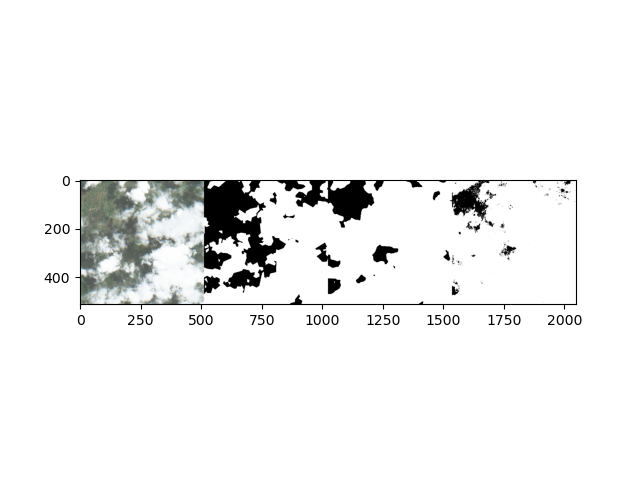

In [5]:
def load_image_and_pred_from_index(index, include_gbm=True):
    ichunk = index//chunksize
    ind_in_chunk = index % chunksize
    
    ind_start = ichunk*chunksize
    ind_end = min(nchips_total, (ichunk+1)*chunksize)
    
    B02 = np.load(NUMPY_ARRAY_DIR + f"B02_{ind_start:06}_{ind_end:06}.npy", mmap_mode='r')[ind_in_chunk]
    B03 = np.load(NUMPY_ARRAY_DIR + f"B03_{ind_start:06}_{ind_end:06}.npy", mmap_mode='r')[ind_in_chunk]
    B04 = np.load(NUMPY_ARRAY_DIR + f"B04_{ind_start:06}_{ind_end:06}.npy", mmap_mode='r')[ind_in_chunk]

    image_true_color = np.stack([
        true_color_band(B04),
        true_color_band(B03),
        true_color_band(B02),
    ],
        axis=-1).astype(np.uint8)

    label = np.load(NUMPY_ARRAY_DIR + f"labels_{ind_start:06}_{ind_end:06}.npy", mmap_mode='r')[ind_in_chunk]
    pred = np.load(NUMPY_ARRAY_DIR + f"preds_{ind_start:06}_{ind_end:06}.npy", mmap_mode='r')[ind_in_chunk]
    label_rgb = (np.broadcast_to(label[..., None], label.shape+(3,))*255).astype(np.uint8)
    pred = (np.broadcast_to(pred[..., None], pred.shape+(3,))*255).astype(np.uint8)
    
    if include_gbm:
        pred_gbm = np.load(NUMPY_ARRAY_DIR + f"preds_gbm_{ind_start:06}_{ind_end:06}.npy", mmap_mode='r')[ind_in_chunk]
        pred_gbm = (np.broadcast_to(pred_gbm[..., None], pred_gbm.shape+(3,))*255).astype(np.uint8)

        image_plot = np.concatenate((image_true_color, label_rgb, pred, pred_gbm), axis=1)

    else:
        image_plot = np.concatenate((image_true_color, label_rgb, pred), axis=1)

    print(image_true_color.shape, label_rgb.shape, pred.shape)

    return image_plot

im = load_image_and_pred_from_index(1)   
plt.imshow(im)
plt.show()

MIN, MAX =  0 10000
MIN, MAX =  0 10000
MIN, MAX =  0 10000
(512, 512, 3) (512, 512, 3) (512, 512, 3)


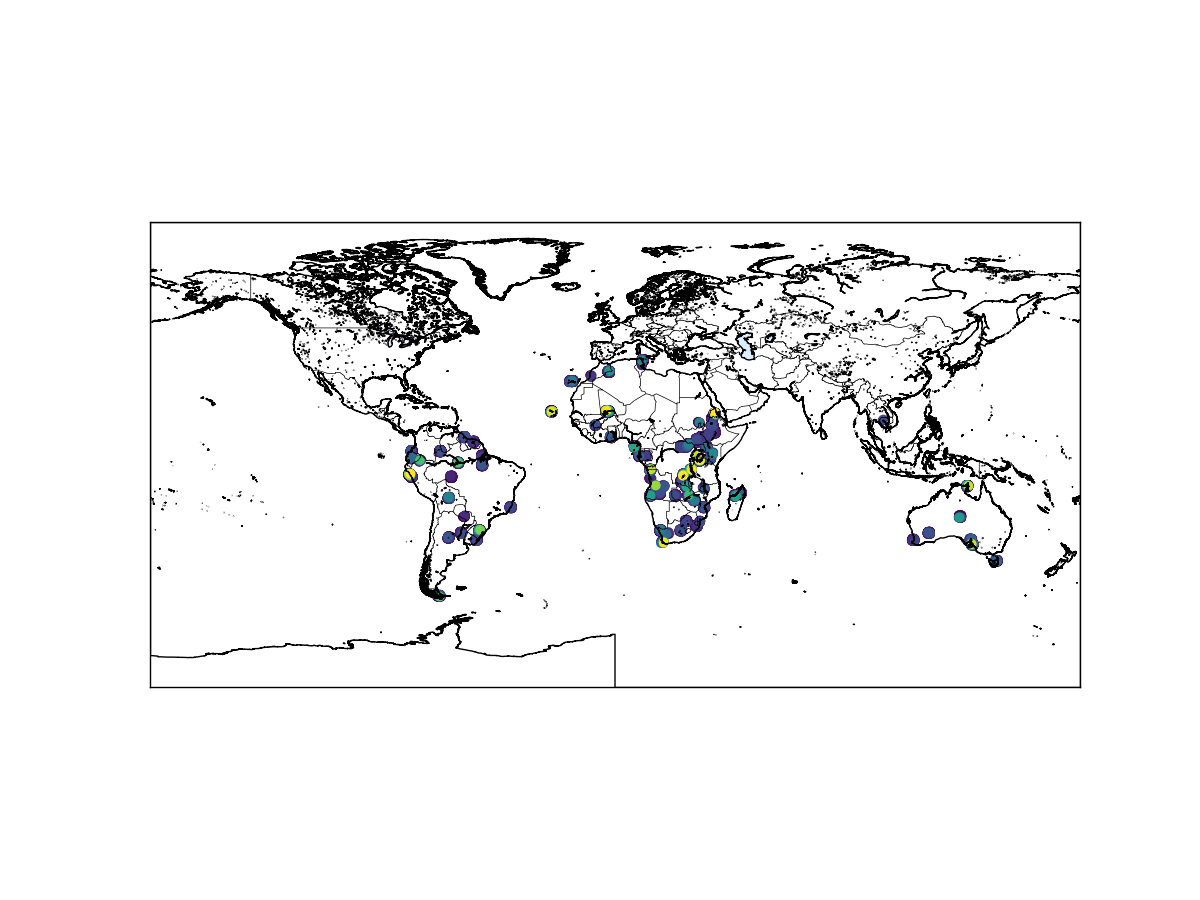

In [6]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# import geopandas as gpd

import os
os.environ["PROJ_LIB"] = "/global/homes/g/gstein/.conda/envs/cloud-seg/bin"; #fixr

from mpl_toolkits.basemap import Basemap


df = pd.DataFrame(data=np.c_[data['lat'], data['lon']],
                  columns=['lat', 'lon'])


fig, ax = plt.subplots(figsize=(12,9))

# world.plot(color="lightgrey", ax=ax)
# world.boundary.plot(color="lightgrey", ax=ax)

m = Basemap(projection='cyl', resolution='h',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
# draw_map(m)
m.fillcontinents(color="#FFFFFF", lake_color='#DDEEFF')
m.drawmapboundary()#fill_color="#DDEEFF")
m.drawcoastlines()
m.drawcountries()

line, = ax.plot(df['lon'], df['lat'], ls="", marker=".",  color='k', alpha=0.0)

inds_sort = np.argsort(data['worst_preds'])
ax.scatter(df['lon'][inds_sort], df['lat'][inds_sort], marker="o", c=data['worst_preds'][inds_sort])

# line, = ax.scatter(df['lon'], df['lat'], c=worst_preds)#ls="", marker="o",  #'orangered')



# create the annotations box
im = OffsetImage(load_image_and_pred_from_index(0)   , zoom=0.2)
xybox=(75., 75.)
im_loc = (-100, 60) 
ab = AnnotationBbox(im,
                    im_loc,
                    xybox=xybox,
                    xycoords='data',
                    boxcoords="offset points",
                    pad=0.3,
                    arrowprops=dict(arrowstyle="->"))
# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):
    # if the mouse is over the scatter points
    if line.contains(event)[0]:
        # find out the index within the array from the event
        ind, = line.contains(event)[1]["ind"]
        # get the figure size
        w,h = fig.get_size_inches()*fig.dpi
        ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
        hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
        # if event occurs in the top or right quadrant of the figure,
        # change the annotation box position relative to mouse.
        ab.xybox = (xybox[0]*ws, xybox[1]*hs)
        # make annotation box visible
        ab.set_visible(True)
        
        # place it at the position of the hovered scatter point
        ab.xy =(df.iloc[ind]['lon'], df.iloc[ind]['lat'])
        
        # set the image corresponding to that point
        im.set_data(load_image_and_pred_from_index(data['inds_orig'][ind]))
        
    else:
        #if the mouse is not over a scatter point
        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)           
plt.show()

In [7]:
import ipympl
ipympl.__version__

'0.8.6'